In [1]:
import pandas as pd
import numpy as np
import re
from utils import *
import json
import random
pd.set_option('display.max_colwidth', None)

In [2]:
def read_results(model,dataset):
    if dataset != 'mm':
        df_cot = pd.read_csv(f'results/{model}/{model}-{dataset}-cot.csv')
        df_sub = pd.read_csv(f'results/{model}/{model}-{dataset}-sub.csv')
        df_pot = pd.read_csv(f'results/{model}/{model}-{dataset}-pot.csv')
    else:
        df_cot_parts,df_sub_parts,df_pot_parts = [],[],[]
        for i in range(5):
            df_cot_parts.append(pd.read_csv(f'results/{model}/{model}-{dataset}-cot-part{i+1}.csv'))
            df_sub_parts.append(pd.read_csv(f'results/{model}/{model}-{dataset}-sub-part{i+1}.csv'))
            df_pot_parts.append(pd.read_csv(f'results/{model}/{model}-{dataset}-pot-part{i+1}.csv'))
        df_cot = pd.concat(df_cot_parts).reset_index(drop=True)
        df_sub = pd.concat(df_sub_parts).reset_index(drop=True)
        df_pot = pd.concat(df_pot_parts).reset_index(drop=True)
    return df_cot, df_sub, df_pot

In [3]:
df_cot, df_sub, df_pot = read_results('mistral','gsm-test')

In [4]:
#We are interested whether the answers given by various strategies are correct. 
#We are also interested if any of the strategies can give correct answer to a question.
def process_results(df_cot,df_sub,df_pot,dataset,model):
    cot_output = df_cot['output_answer']
    sub_output = df_sub['output_answer']
    pot_output = df_pot['output_answer']
    data_all = np.array([[x.split('Input:\n')[-1].split('Response:\n')[0][:-1] for x in df_cot['prompts']],
                  [extract_pred(x) for x in cot_output],
                  [extract_pred(x) for x in sub_output],
                  [extract_pred_math_solver(x) for x in pot_output],
                  df_sub['correct_answer']])
    print(np.mean([len(x) for x in df_cot['output_answer']]))
    print(np.mean([len(x) for x in df_sub['output_answer']]))
    df_all = pd.DataFrame(data_all.T,columns=['question','cot-answer','sub-answer','pot-answer','correct-answer'])
    df_all['cot-answer'] = df_all['cot-answer'].astype(float)
    df_all['sub-answer'] = df_all['sub-answer'].astype(float)
    df_all['pot-answer'] = df_all['pot-answer'].astype(float)
    df_all['correct-answer'] = df_all['correct-answer'].astype(float)
    df_all['cot-correct'] = (df_all['cot-answer'] - df_all['correct-answer']).abs() < 1e-6
    df_all['sub-correct'] = (df_all['sub-answer'] - df_all['correct-answer']).abs() < 1e-6
    df_all['pot-correct'] = (df_all['pot-answer'] - df_all['correct-answer']).abs() < 1e-6
    df_all['correct'] = (df_all['sub-answer'] == df_all['correct-answer']) | \
                        (df_all['cot-answer'] == df_all['correct-answer']) | \
                        (df_all['pot-answer'] == df_all['correct-answer'])
    print(np.mean(df_all['cot-correct']))
    print(np.mean(df_all['sub-correct']))
    print(np.mean(df_all['pot-correct']))
    print(np.mean(df_all['correct']))
    print()
    df_all.to_csv(f'results-all-{model}-{dataset}.csv',index=False)

def find_best_strategy(df):
    res = []
    ao_correct = df['ao-correct']
    cot_correct = df['cot-correct']
    sub_correct = df['sub-correct']
    for i in range(len(df)):
        if ao_correct[i]:
            res.append('Answer Only')
        elif cot_correct[i]:
            res.append('Chain of Thought')
        elif sub_correct[i]:
            res.append('Sub-questioning')
        else:
            res.append('Unsolvable')
    return res


In [5]:
process_results(df_cot,df_sub,df_pot,'gsm-test','mistral')


426.85367702805155
549.9446550416983
0.5064442759666414
0.5238817285822593
0.5693707354056103
0.7619408642911296



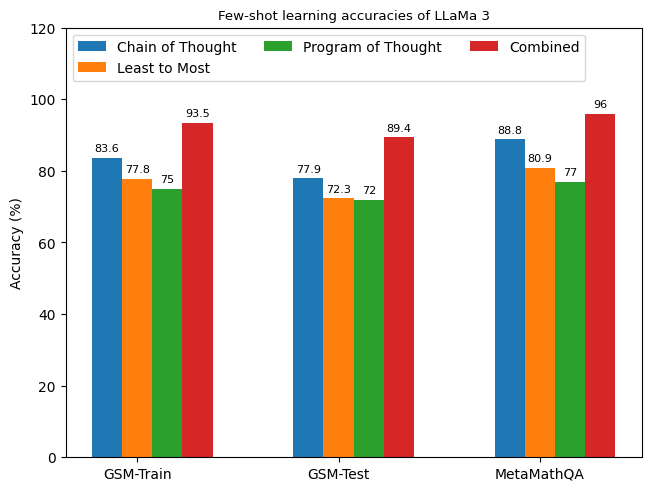

In [6]:
import matplotlib.pyplot as plt
import numpy as np

data = ("GSM-Train", "GSM-Test", "MetaMathQA")
accuracies = {
    'Chain of Thought': (83.6, 77.9, 88.8),
    'Least to Most': (77.8, 72.3, 80.9),
    'Program of Thought': (75, 72, 77),
    'Combined': (93.5,89.4,96)
}

x = np.arange(len(data))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
plt.rcParams['font.size'] = 8
for attribute, measurement in accuracies.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)')
ax.set_title('Few-shot learning accuracies of LLaMa 3')
ax.set_xticks(x + width, data)
# ax.set_yticks(fontsize=10)
ax.legend(loc='upper left', ncols=3, fontsize=10)
ax.set_ylim(0, 120)

plt.show()